<center><h1>Tutorial 3 - Measures </h1>
<br>Mary K. Coe <br>
21 Nov 2021</center>

By the end of this tutorial you will be able to
    - Calculate various thermodynamic measures within a DFT system.
    - Find the liquid-vapour surface tension of a fluid.
    - Calculate various fluctuation profiles.

<h3>Introduction</h3>
This tutorial assumes that you already have a general understanding of what classical density functional theory (cDFT) is and how it works, and that <b>you have completed Tutorial 1 - Hard-Sphere Fluids and Tutorial 2 - Lennard-Jones Fluids</b>. If you require more background, please consult the following resources.

<a href = "https://doi.org/10.1080/00018737900101365"> R. Evans, Advances in Physics <b>28</b>, 143-200 (1979)</a> - This is a famous review article by Prof Bob Evans which covers most of the maths behind cDFT.

<a href="https://doi.org/10.1088/0953-8984/22/6/063102">R Roth, J. Phys.:Condens. Matter <b>22</b>, 0631102 (2010)</a> - This is a review article by Prof Roland Roth which covers the theory and implementation of Fundamental Measure Theory (FMT). This also describes all functionals available within the package.

M. K. Coe, "Hydrophobicity across length scales: The role of surface criticality", PhD thesis, (University of Bristol, 2021) - My thesis, available Dec 2021. Chapter 4 as well as Appendices A-C cover the implementation of cDFT within this package in depth.

In addition to a basic knowledge of cDFT, you will need a Python installation with the standard libraries, as well as the <i>NumPy</i>, <i>SciPy</i>, <i>Matplotlib</i> and <i>pyfftw</i> libraries. The latter of these is the python wrapper for the fast fourier transforms library, FFTW. 

<b>Warning</b> - I have noticed that pyfftw does not respect core allocation on nodes on a cluster. For example, if you request one core on one node, pyfftw appears to automatically use all cores within the node. If using the package on a cluster, it is therefore recommended you run it using mpiexec or equivalent, to force it to use only the requested number of cores.

With this in mind, we begin the tutorial by importing necessary libraries.

In [1]:
# Import necessary libraries for tutorial
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors

import cDFT.minimisation as minimise
import cDFT.measures as measure

<h3>Thermodynamic Measures</h3>
In the previous tutorials, we looked at how to find the equilibrium density profiles of various fluids subjected to various external potentials and walls. The purpose of this tutorial is to show you how we can use these profiles to calculate other measures of the system.

<h4>Bulk Measures - Pressure and Chemical Potential</h4>
Measures such as the pressure and chemical potential are calculated when defining a <i>DFT</i> object. They can be accessed as follows

In [2]:
LJ = minimise.DFT(bulk_density = 0.59803, # Density at a slight oversaturation
                  temperature = 1.02257,  # Equivalent to 0.775Tc
                  fluid_type = 'TLJ',     # Truncated Lennard-ones fluid
                  cut_off = 2.5           # Cut-off radius of interaction
                 )

LJ.information()

Fluid type: truncated Lennard-Jones fluid with cut-off radius of interaction 2.5 * diameter of a fluid particle
Temperature: 1.02257
Density of bulk fluid: 0.59803
Functional: Rosenfeld
Length of grid: 50.0 * diameter of a fluid particle
Distance between grid points: 0.001 * diameter of a fluid particle


In [3]:
pressure = LJ.pressure
excess_chemical_potential = LJ.mu
ideal_chemical_potential = LJ.T*np.log(LJ.bulk_density)

print(f'Pressure = {pressure}')
print(f'Excess Chemical Potential = {excess_chemical_potential}')
print(f'Ideal Chemical Potential = {ideal_chemical_potential}')
print(f'Chemical Potential = {excess_chemical_potential+ideal_chemical_potential}')

Pressure = 0.029678699281701082
Excess Chemical Potential = -3.2749077381595972
Ideal Chemical Potential = -0.5257179201498724
Chemical Potential = -3.8006256583094697


The pressure calculated within <i>LJ</i> contains both the ideal and excess components. In contrast, the chemical potential (<i>LJ.mu</i>) calculated within <i>LJ</i> is the excess component only. This is because the DFT minimisation procedure requires only the excess component. The ideal component of the chemical potential can be calculated by multiplying the reduced temperature (<i>LJ.T</i>) by the log of the bulk density. The full chemical potential is then found by adding the excess and ideal components.

Accessing these measures is simpler if you have already defined a geometry to work in. For example, within the planar geometry, these can be found using the following methods.

In [4]:
planar = minimise.planar(LJ, wall_type = 'SLJ', epsilon_wall = 0.5)

pressure = planar.pressure()
excess_chemical_potential = planar.chemical_potential(excess = True)
ideal_chemical_potential = planar.chemical_potential(ideal = True)
chemical_potential = planar.chemical_potential()

print(f'Pressure = {pressure}')
print(f'Excess Chemical Potential = {excess_chemical_potential}')
print(f'Ideal Chemical Potential = {ideal_chemical_potential}')
print(f'Chemical Potential = {chemical_potential}')

Pressure = 0.029678699281701082
Excess Chemical Potential = -3.2749077381595972
Ideal Chemical Potential = -0.5257179201498724
Chemical Potential = -3.8006256583094697


Please note, if both <i>excess</i> and <i>ideal</i> are set to true in the <i>chemical_potential</i> method, both are returned in the form <i>excess_chemical_potential, ideal_chemical_potential</i>.

<h4>Surface Measures - Surface Tension, Adsorption, Contact Density</h4>
    
Surface measures can only be found once a geometry object has been defined, and will only produce sensible results if the equilibrium profile has first been found. The safest way to evaluate these measures is to use the methods within the geometry objects. 

In [5]:
# First find the equilibrium profile
planar.minimise()

Convergence achieved in 247 attempts.


In [6]:
# These methods have the additional option of writing the
# result to the output file.
grand_potential = planar.grand_potential(write_to_file = False)
surface_tension = planar.surface_tension(write_to_file = False)

# The results of these measures are automatically written
# to the output file during the minimisation process.
adsorption = planar.adsorption()
contact_density = planar.contact_density()

print(f'Grand Potential = {grand_potential}')
print(f'Surface Tension = {surface_tension}')
print(f'Adsorption = {adsorption}')
print(f'Contact Density = {contact_density}')

Grand Potential = -1.2595017938179902
Surface Tension = 0.22443317026706391
Adsorption = -0.6454890319579266
Contact Density = 0.1438449693682311


Note that within the package, the adsorption and surface tension are defined from the accessible volume - e.g. where the density profile is allowed to be non-zero. 

An alternative method to find these measures is to directly call various measure functions from the <i>measures</i> module. These functions take a <i>planar</i>, <i>spherical</i> or <i>slit</i> object as a required argument and two bools, <i>pout</i> (short for print out) and <i>fout</i> (short for file out), as optional arguments. These latter two determine whether to output the results of the measures to the screen or to the output file respectively. Note calling these functions directly from the measures module will mean the package does not first check that the equilibrium profile has been found.

In [7]:
grand_potential = measure.grand_potential(planar, pout = True, fout = True)
surface_tension = measure.surface_tension(planar, pout = True, fout = True)
adsorption = measure.adsorption(planar, pout = True, fout = True)

# Note that the contact density does not have a measure function.
# Instead you can find it using
contact_density = planar.DFT.density[planar.NiW]
print(f'Contact Density = {contact_density:.5f}')

Grand Potential = -1.25950
Surface Tension = 0.22443
Adsorption = -0.64549
Contact Density = 0.14384


Whilst we have demonstrated these measures for the <i>planar</i> geometry, they are available in all geometries.

<h3>Liquid-Vapour Surface Tension</h3>

The <i>measures</i> module features a function to find the liquid-vapour surface tension of a Lennard-Jones fluid. As required arguments, this function takes the temperature, vapour density and liquid density. As optional arguments, the hard-sphere function, cut-off and output file path may be specified. Note - it is important that you give the function accurate values for the coexisting liquid and vapour densities at the temperature of interest. If these are not highly accurate, the results of the function will be spurious.

In [8]:
lv_surface_tension = measure.liquid_vapour_surface_tension(
                        temperature = 1.0225672588,
                        vapour_density = 0.0343066397783,
                        liquid_density = 0.597844705492,
                        functional='RF',
                        cut_off = 2.5,
                        file_path = './Surface_Tension/')

100 complete. Deviation: 0.0010453110821239675

200 complete. Deviation: 0.0006477881010000242

300 complete. Deviation: 0.00039970355385482437

400 complete. Deviation: 0.0002461757120754693

500 complete. Deviation: 0.00015158234329687437

600 complete. Deviation: 9.340646614308667e-05

700 complete. Deviation: 5.764060189261677e-05

800 complete. Deviation: 3.564007533701785e-05

900 complete. Deviation: 2.2090847975664296e-05

1000 complete. Deviation: 1.3732223826834478e-05

1100 complete. Deviation: 3.699476347485131e-08

1200 complete. Deviation: 2.474294980014946e-08

1300 complete. Deviation: 1.7102287697134955e-08

1400 complete. Deviation: 1.2261367920984867e-08

1500 complete. Deviation: 8.93248475186681e-09

1600 complete. Deviation: 6.566753585346419e-09

1700 complete. Deviation: 4.890430505000154e-09

1800 complete. Deviation: 3.6334955044736716e-09

1900 complete. Deviation: 2.6950061071673304e-09

2000 complete. Deviation: 1.9965959996426363e-09

2100 complete. Deviat

<h3>Fluctuation Profiles</h3>

In recent years several measures of local density fluctuations have been proposed. The package implements two of these, called the local compressibility ($\chi_{\mu}$) and local thermal susceptibility ($\chi_T$), defined as
\begin{equation}
    \chi_{\mu}(\mathbf{r}) = \left(\frac{\partial\rho(\mathbf{r})}{\partial \mu}\right)_{T} \qquad\qquad \chi_T(\mathbf{r}) = \left(\frac{\partial\rho(\mathbf{r})}{\partial T}\right)_{\mu}
\end{equation}
where $\rho(\mathbf{r})$ is the density profile of the fluid, $T$ is the temperature and $\mu$ is the chemical potential. For more information on the local compressibility, see <a href = https://doi.org/10.1088/0953-8984/27/19/194111>this paper</a>. For more information of the local thermal susceptibility, please see <a href = https://doi.org/10.1103/PhysRevLett.125.268004>this paper</a>.

$\chi_{\mu}$ and $\chi_T$ can be evaluated during the minimisation process to find the equilibrium density profile by setting the <i>compressibility</i> and <i>susceptibility</i> flags to <i>True</i>. If these profiles have been found, they will be returned when calling the <i>equilibrium_profile</i> method. Below we demonstrate these fluctuation profiles for a truncated Lennard-Jones fluid in contact with an attractive planar wall.

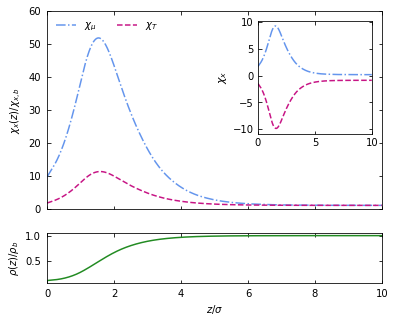

In [16]:
def plot_profiles(planar):
    """
    Plots the density, local compressibility and
    local thermal susceptibility profiles for a
    planar object.
    
    Parameters
    ----------
    planar: minimise.planar object
        Planar object with minimise method called.
        
    Returns
    -------
    None.
    """
    
    fig = plt.figure(figsize = (6,5))
    gs = fig.add_gridspec(ncols=1, nrows = 2, height_ratios = [4,1])
    
    # Define density and fluctuation axes
    ax_dens = fig.add_subplot(gs[1,0])
    ax_fluc = fig.add_subplot(gs[0,0])
    
    # Get profiles
    z, density, compressibility, susceptibility = planar.equilibrium_profile()
    
    # Get bulk values for scaling
    bulk_density = planar.DFT.bulk_density
    bulk_compressibility = planar.bulk_compressibility
    bulk_susceptibility = planar.bulk_susceptibility
    
    # Find number of grid points to use
    L = int(10./planar.DFT.dr)
    
    # Plot density profile
    ax_dens.plot(z[:L], density[:L]/bulk_density, color = 'forestgreen', ls = 'solid')
    
    # Axes parameters
    ax_dens.set_xlim(0.0,10.0)
    ax_dens.tick_params(which = 'both', direction = 'in', pad = 6, top = True, right = True)
    ax_dens.set_xlabel(r'$z/\sigma$')
    ax_dens.set_ylabel(r'$\rho(z)/\rho_b$')

    # Plot fluctuation profiles
    ax_fluc.plot(z[:L], compressibility[:L]/bulk_compressibility,
                 color = 'cornflowerblue', ls = '-.', label = r'$\chi_{\mu}$')
    ax_fluc.plot(z[:L], susceptibility[:L]/bulk_susceptibility,
                 color = 'mediumvioletred', ls = 'dashed', label = r'$\chi_{T}$')
    
    max_compressibility = np.amax(compressibility[:L]/bulk_compressibility)
    maxy = 10.*np.ceil(max_compressibility/10.)

    # Axes parameters
    ax_fluc.set_xlim(0.0,10.0)
    ax_fluc.set_ylim(0.0,maxy)
    ax_fluc.tick_params(which = 'both', direction = 'in', top = True, right = True, pad = 6)
    ax_fluc.set_xticklabels([])
    ax_fluc.set_ylabel(r'$\chi_{x}(z)/\chi_{x,b}$')

    # Add inset to fluctuations plot
    ax_inset = ax_fluc.inset_axes([0.63,0.38,0.34,0.57])
    ax_inset.plot(z[:L], compressibility[:L], color = 'cornflowerblue', ls = '-.')
    ax_inset.plot(z[:L], susceptibility[:L], color = 'mediumvioletred', ls = 'dashed')

    # Inset axes parameters
    ax_inset.set_xlim(0.0,10.0)

    ax_inset.tick_params(which = 'both', direction = 'in', top = True, right = True, pad = 4)
    ax_inset.set_ylabel(r'$\chi_{x}$', fontsize = 11)

    ax_fluc.legend(frameon=False, ncol = 2, loc = 'upper left')
    
    
planar = minimise.planar(LJ,
                        wall_type = 'SLJ',
                        epsilon_wall = 0.1,
                        compressibility = True,
                        susceptibility = True
                        )

planar.minimise()
plot_profiles(planar)

These fluctuation profiles are also written to the output file under the headings <i>chi_mu</i> and <i>chi_mu/chi_mu_bulk</i> for the local compressibility and under <i>chi_T</i> and <i>chi_T/chi_T_bulk</i> for the local thermal susceptibility. These measures are also availble in the spherical and slit geometries.

<h3>Summary</h3>

Within these three tutorials we have explored the basic functions of the package for hard-sphere fluids (Tutorial 1), Lennard-Jones fluids (Tutorial 2) and the available measures (this tutorial). You should now have enough understanding to make good use of the package. Enjoy!

If you want to see some of the things this package has been used for, check out these references:

M. K. Coe, "Hydrophobicity across length scales: The role of surface criticality", PhD thesis, (University of Bristol, 2021) - (available Dec 2021)

<i>We are currently preparing several papers - these will be added when available.</i>